# 04 Text Summarizing


## Import Libraries

In [2]:
import re

import datetime
import numpy as np
import pandas as pd
from datetime import date 

###
import pymongo

### NLP

import gensim
import spacy

### Custom Utils
from text_utils.metrics import get_chunks_info, get_metric

 

## Import sample text

In [3]:
## for remote 

# try:
#     client = pymongo.MongoClient('192.168.1.42',
#                                  username='syamil',
#                                  password='Rskfazw9..',
#                                  authMechanism='SCRAM-SHA-256')
#     client.server_info() # force connection on a request as the
#                          # connect=True parameter of MongoClient seems
#                          # to be useless here 
# except pymongo.errors.ServerSelectionTimeoutError as err:
#     # do whatever you need
#     print(err)
    
## for local
try:
    client = pymongo.MongoClient("mongodb://localhost:27017/")
    client.server_info() # force connection on a request as the
                         # connect=True parameter of MongoClient seems
                         # to be useless here 
except pymongo.errors.ServerSelectionTimeoutError as err:
    # do whatever you need
    print(err)



In [4]:
db = client["parliament"]
articles = db["articles"]

In [5]:
articles.find_one()['cleaned_join'][:400]

'[(proc text) Debate resumed. (proc text)]<br/>Mr Deputy Speaker: Mr Png Eng Huat.6.57 pm<br/>Mr Png Eng Huat (Hougang): Sir, if this Bill is drafted solely to target the perpetrators of hate, violence, intolerance and disdain towards another race or religion, by all means, let us do it. We should never allow such people to propagate their vile ideologies in any form or manner. This world has no pl'

In [6]:
mongo_df = pd.DataFrame.from_records(articles.find())

In [7]:
mongo_df.head()

,_id,article_text,chunks,cleaned_join,dominant_topic,html_clean,parliament_num,parsed_convo,persons_involved,session_num,session_type,sitting_date,sitting_num,src_url,title,volume_num
0,5d27eca6172d9aa762d4802f,<p>[(proc text) Debate resumed. (proc text)]</...,[{'content': '[(proc text) Debate resumed. (pr...,[(proc text) Debate resumed. (proc text)]<br/>...,Society,"[[(proc text) Debate resumed. (proc text)], Mr...",13,[{'content': '[(proc text) Debate resumed. (pr...,"[Prof Lim Sun Sun, Miss Cheng Li Hui, An hon M...",2,SECOND READING BILLS,2019-05-08,105,https://sprs.parl.gov.sg/search/sprs3topic?rep...,PROTECTION FROM ONLINE FALSEHOODS AND MANIPULA...,94
1,5d27eca6172d9aa762d48030,"<p class=""ql-align-justify"">4 <strong>Mr Vikra...",[{'content': 'Mr Vikram Nair asked the Ministe...,Mr Vikram Nair asked the Minister for Foreign ...,Society,[Mr Vikram Nair asked the Minister for Foreign...,13,[{'content': 'Mr Vikram Nair asked the Ministe...,"[Mr Speaker, Assoc Prof Walter Theseira, Mr Vi...",2,ORAL ANSWERS,2019-05-08,105,https://sprs.parl.gov.sg/search/sprs3topic?rep...,STATE OF BILATERAL RELATIONS WITH MALAYSIA FOL...,94
2,5d27eca6172d9aa762d48031,"<p class=""ql-align-justify"">8 <strong>Assoc Pr...",[{'content': 'Assoc Prof Walter Theseira asked...,Assoc Prof Walter Theseira asked the Minister ...,Internal Security,[Assoc Prof Walter Theseira asked the Minister...,13,[{'content': 'Assoc Prof Walter Theseira asked...,"[Ms Anthea Ong, Assoc Prof Walter Theseira, Ms...",2,ORAL ANSWERS,2019-05-08,105,https://sprs.parl.gov.sg/search/sprs3topic?rep...,COMPANIES WITH MEASURES TO DEAL WITH WORKPLACE...,94
3,5d27eca6172d9aa762d48032,<p>5 <strong>Ms Irene Quay Siew Ching</strong>...,[{'content': 'Ms Irene Quay Siew Ching asked t...,Ms Irene Quay Siew Ching asked the Minister fo...,Environment,[Ms Irene Quay Siew Ching asked the Minister f...,13,[{'content': 'Ms Irene Quay Siew Ching asked t...,"[Ms Irene Quay Siew Ching, Dr Lam Pin Min, The...",2,ORAL ANSWERS,2019-05-08,105,https://sprs.parl.gov.sg/search/sprs3topic?rep...,REVIEW OF DRUG TESTING STANDARDS IN SINGAPORE ...,94
4,5d27eca6172d9aa762d48033,"<p class=""ql-align-justify"">2 <strong>Mr Lim B...",[{'content': 'Mr Lim Biow Chuan asked the Depu...,Mr Lim Biow Chuan asked the Deputy Prime Minis...,Employment,[Mr Lim Biow Chuan asked the Deputy Prime Mini...,13,[{'content': 'Mr Lim Biow Chuan asked the Depu...,"[The Second Minister for Finance, Mr Lim Biow ...",2,ORAL ANSWERS,2019-05-08,105,https://sprs.parl.gov.sg/search/sprs3topic?rep...,LIVING IN PRIVATE PROPERTIES BUT WITH NO DECLA...,94


## Extractive Summarization using TextRank

Source : https://www.aclweb.org/anthology/W04-3252

In [113]:
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
import pprint

import networkx as nx

### Step 0 : Import in Sample Text

In [23]:
sample_text = mongo_df.iloc[1300].cleaned_join
display(sample_text)

'Mr Lim Biow Chuan asked the Minister for National Development (a) whether a traffic impact assessment had been carried out prior to having the construction staging ground located at Marina East; and (b) when will this temporary staging ground be relocated.<br/>Mr Lawrence Wong: The temporary occupation licence (TOL) for the construction staging ground at Marina East was first issued to LTA in 2014, before activities in the area generated significant traffic impact. In 2016, arising from new TOL applications in the East Coast/Marina Bay area, a joint Traffic Impact Assessment (TIA) was carried out for the TOLs in the East Coast/Marina Bay area, as they share the same access road. The Marina East staging ground is segregated from the existing residential area by East Coast Parkway and East Coast Park. Nevertheless, LTA has adopted measures to minimise dis-amenities to road users in the vicinity. For example, queue bays are provided in the staging ground, and throughput has been enhanced

## Step 1 : Extract Sentences from sample

In this step, we will be splitting the text into sentences by using python's `.split()` method. Additionally, we will be doing some pre-processing as part of the process which includes removing stop words as well as stemming. 

The function `process_text` takes in a string of text (or in this case, the document) and then outputs a list of post-processed strings where each item on the list is a processed string.

Furthermore, we will ignore the text at index 0 as this is typically the question statement and we are only interested in responses.

In [263]:
stop_words = set(stopwords.words("english"))

def process_text(text,stopwords = None):
    text = text.replace('<br/>',' ')
    split_text = text.split('.')
    sentences = [sentence for sentence in split_text if len(sentence) > 1]
    
    process_sentences = []
    
    ## remove stopwords
    for sentence in sentences:
        words = sentence.split()
        processed_words = [word.lower() for word in words if word not in stopwords]
        process_sentences.append(" ".join(processed_words))
    
    return process_sentences[1:]

processed_text = process_text(sample_text,stop_words)
display(processed_text)

['mr lawrence wong: the temporary occupation licence (tol) construction staging ground marina east first issued lta 2014, activities area generated significant traffic impact',
 'in 2016, arising new tol applications east coast/marina bay area, joint traffic impact assessment (tia) carried tols east coast/marina bay area, share access road',
 'the marina east staging ground segregated existing residential area east coast parkway east coast park',
 'nevertheless, lta adopted measures minimise dis-amenities road users vicinity',
 'for example, queue bays provided staging ground, throughput enhanced heavy vehicles overflow public roads',
 'lta also working closely developers contractors area develop localised traffic control plans improve safety minimise inconvenience road users',
 'these include managing schedules routes heavy vehicles avoid peak hour traffic residential areas, possible',
 'there also signs alert motorists slow watch heavy vehicles',
 'from land-use perspective, marina e

## Step 2 : Vectorizing our Text

In this step, the sentences are then converted to Term-Frequency Inverse Document Frequency (TF-IDF). TF-IDF is used in this case over the Bag of Words (BoW) approach to penalise frequently occuring words within the same text. In plain speak, it's similar to assigning weights over the occurances of a certain word. If the word occurs more frequently, then the value is lower. Likewise, rarely accuring words are then given higher values. 

In [264]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
sent_vectors = vectorizer.fit_transform(processed_text)

To better understand what is happening below the hood, a dataframe containing the vectors mapped to their associated word is shown below.

In [265]:
pd.DataFrame(sent_vectors.todense().tolist(),columns=vectorizer.get_feature_names())

,2014,2016,access,activities,adopted,alert,also,amenities,applications,area,...,traffic,use,users,vehicles,vicinity,watch,when,whether,wong,working
0,0.235868,0.00000,0.00000,0.235868,0.000000,0.000000,0.000000,0.000000,0.00000,0.140063,...,0.155963,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.235868,0.000000
1,0.000000,0.19567,0.19567,0.000000,0.000000,0.000000,0.000000,0.000000,0.19567,0.232386,...,0.129383,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.160048,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.00000,0.00000,0.000000,0.346693,0.000000,0.000000,0.346693,0.00000,0.000000,...,0.000000,0.000000,0.294720,0.000000,0.346693,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.216402,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.222823,0.000000,0.00000,0.155651,...,0.173319,0.000000,0.222823,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.262117
6,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.188798,0.000000,0.000000,0.212354,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.00000,0.00000,0.000000,0.000000,0.357395,0.303819,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.265806,0.000000,0.357395,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.257492,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.169831,...,0.000000,0.243123,0.000000,0.000000,0.000000,0.000000,0.285997,0.285997,0.000000,0.000000


## Step 3 : Build Similarity Matrix

In this step, a similarity matrix is created by applying a dot product with the sentence vector and its transpose.

In [266]:
sim_matrix = np.round(np.dot(sent_vectors, sent_vectors.T).A,3)

Again, we display this matrix as part of a correlation table.

In [267]:
corr = pd.DataFrame(columns=range(len(processed_text)),index=range(len(processed_text)),data=sim_matrix)
display(corr)

,0,1,2,3,4,5,6,7,8,9
0,1.000,0.200,0.224,0.036,0.048,0.076,0.029,0.000,0.144,0.071
1,0.200,1.000,0.374,0.030,0.000,0.081,0.024,0.000,0.130,0.039
2,0.224,0.374,1.000,0.000,0.055,0.025,0.056,0.000,0.200,0.082
3,0.036,0.030,0.000,1.000,0.000,0.211,0.000,0.000,0.092,0.000
4,0.048,0.000,0.055,0.000,1.000,0.000,0.092,0.115,0.062,0.059
5,0.076,0.081,0.025,0.211,0.000,1.000,0.033,0.068,0.069,0.081
6,0.029,0.024,0.056,0.000,0.092,0.033,1.000,0.113,0.000,0.000
7,0.000,0.000,0.000,0.000,0.115,0.068,0.113,1.000,0.000,0.000
8,0.144,0.130,0.200,0.092,0.062,0.069,0.000,0.000,1.000,0.186
9,0.071,0.039,0.082,0.000,0.059,0.081,0.000,0.000,0.186,1.000


And if we wanted to visualise it using seaborn:

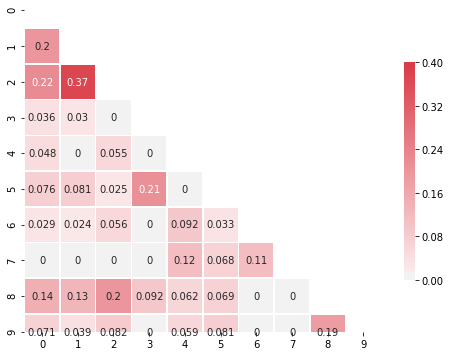

In [268]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap,annot=True, vmax=0.4, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

We can already see how sentences are similar to each other just by comparing their positions in their table. For example, we see that sentence 1 and 2 are very similar.


In [285]:
print(f"Sentence 1 : {processed_text[1]}")
print(f"Sentence 2 : {processed_text[2]}")

Sentence 1 : in 2016, arising new tol applications east coast/marina bay area, joint traffic impact assessment (tia) carried tols east coast/marina bay area, share access road
Sentence 2 : the marina east staging ground segregated existing residential area east coast parkway east coast park


## Step 4 : Create Similarity Graph

Using the TextRank concept, a network graph is created such that each vertex is the sentence represented by its index, and the edges are linked to each other by weights computed by the similarity scores. 

> The basic idea implemented by a  graph-based ranking model is that of “voting”or“recommendation”. When one vertex links to another one,it is basically casting a vote for that other vertex. The higher the number of votes that are cast for a vertex,the higher the importance of the vertex. Moreover, the importance of the vertex casting the vote determines how important the vote itself is,and this information is also taken into account by the ranking model. Hence,the score associated with a vertex is determined based on the votes that are cast for it,and the score of the vertices casting these votes. ([Mihalcea & Tarau, 2004](https://www.aclweb.org/anthology/W04-3252))

To compute this graph-derived score which is refered to as `TextRank` - similar to Google's PageRank, we import the popular `networkx` package. With network x, we can visualise the similarity matrix as a graph. And using this, we can see 

In [270]:
sentence_similarity_graph = nx.from_numpy_array(sim_matrix)

/Users/syamil/anaconda3/envs/pivot/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


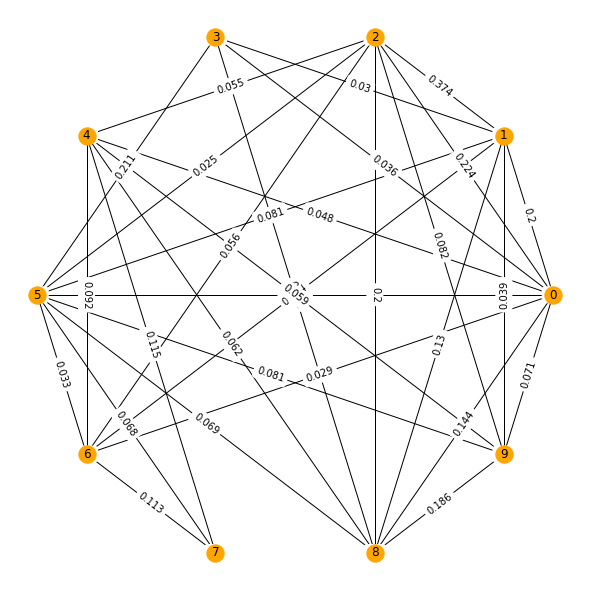

In [271]:
pos = nx.circular_layout(sentence_similarity_graph)
plt.figure(figsize=(8,8))
plt.figure(1)
nx.draw_circular(sentence_similarity_graph, with_labels = True, node_color="Orange")
edge_labels = nx.get_edge_attributes(sentence_similarity_graph, 'weight')
plt.figure(1)
nx.draw_networkx_edge_labels(sentence_similarity_graph,pos=pos, edge_labels=edge_labels)
plt.show()

In [272]:
scores = nx.pagerank(sentence_similarity_graph)
display(scores)

{0: 0.10594604557676923,
 1: 0.10711030046429679,
 2: 0.11410080866901795,
 3: 0.0893971718098718,
 4: 0.09467680498110888,
 5: 0.1019626373096041,
 6: 0.09218045190228014,
 7: 0.09190095545516967,
 8: 0.10932632179093772,
 9: 0.09339850204094387}

## Step 5 : Sorting the Scores

Once we have obtained the scores, we then look at picking the top n sentences that have the highest scores to best represent the text. In this case, we select the top **3** sentences.

In [273]:
original_sentences = [sent for sent in sample_text.replace('<br/>',' ').split('. ') if len(sent)>1]

sorted_sentences = sorted(((scores[idx], sentence) for idx,sentence in enumerate(original_sentences[1:])), reverse=True)
display(sorted_sentences[:3])

[(0.11410080866901795,
  'The Marina East staging ground is segregated from the existing residential area by East Coast Parkway and East Coast Park'),
 (0.10932632179093772,
  'When these projects are completed, we will review whether to continue the use of this staging ground, in connection with the timing of future development plans for the area'),
 (0.10711030046429679,
  'In 2016, arising from new TOL applications in the East Coast/Marina Bay area, a joint Traffic Impact Assessment (TIA) was carried out for the TOLs in the East Coast/Marina Bay area, as they share the same access road')]

## Step 6 : Joining our Extracted Summary and Putting it together

In this step, we will display our Question and Summarised response together to give us a feel of what the end product is.

In [274]:
". ".join([sent[1] for sent in sorted_sentences[:3]])

'The Marina East staging ground is segregated from the existing residential area by East Coast Parkway and East Coast Park. When these projects are completed, we will review whether to continue the use of this staging ground, in connection with the timing of future development plans for the area. In 2016, arising from new TOL applications in the East Coast/Marina Bay area, a joint Traffic Impact Assessment (TIA) was carried out for the TOLs in the East Coast/Marina Bay area, as they share the same access road'

In [275]:
print(f"Question : {original_sentences[0]}")
print(f"\nResponse : {'. '.join([sent[1] for sent in sorted_sentences[0:2]])}.")

Question : Mr Lim Biow Chuan asked the Minister for National Development (a) whether a traffic impact assessment had been carried out prior to having the construction staging ground located at Marina East; and (b) when will this temporary staging ground be relocated

Response : The Marina East staging ground is segregated from the existing residential area by East Coast Parkway and East Coast Park. When these projects are completed, we will review whether to continue the use of this staging ground, in connection with the timing of future development plans for the area.


As you may already see, it is somewhat faithful to the original text. At the same time, it is worth noting that this is a rudimentary implementation of TextRank. 

Many variations of TextRank exist which look at various similarity functions and text vectorisation techniques to improve the summarization capability. One such implementation is by [Barrios et al, 2016](https://arxiv.org/pdf/1602.03606.pdf).

This implementation incorporated the following changes to the steps:
1. Choosing Longest Common Substring
2. BM25 Ranking model (variation of TF-IDF model using probabilistic )

Which you can read more in the paper linked above. 

Consequentially, this variation is baked into the popular `Gensim` package. As a result, we can call out this function very easily as you can see below.


## Enter Gensim

We can use the summarizer function located in the `summarization.summarizer` module.

In [283]:
print(gensim.summarization.summarizer.summarize(sample_text.replace('<br/>',''), ratio=0.3,
                                          word_count=None, split=False))

Mr Lim Biow Chuan asked the Minister for National Development (a) whether a traffic impact assessment had been carried out prior to having the construction staging ground located at Marina East; and (b) when will this temporary staging ground be relocated.Mr Lawrence Wong: The temporary occupation licence (TOL) for the construction staging ground at Marina East was first issued to LTA in 2014, before activities in the area generated significant traffic impact.
LTA is also working closely with the developers and contractors in the area to develop localised traffic control plans to improve safety and minimise inconvenience to other road users.
